# Notebook to address Reviewer 1's comments about the accuracy of online vs offline dissipation of salinity variance $\chi_v^s$

In [1]:
#Packages 
import numpy as np
import xgcm
from xgcm import Grid
import xarray as xr
import xroms
from datetime import datetime

import glob
from xhistogram.xarray import histogram
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import cmocean.cm as cmo
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.ticker as tick
from matplotlib.dates import DateFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.dates as mdates
import pandas as pd
from matplotlib.ticker import AutoMinorLocator

In [ ]:
#Open model output
path = glob.glob('/d1/shared/TXLA_ROMS/numerical_mixing/non-nest/ver1/1hr/ocean_avg_0000*.nc')
# path = glob.glob('/d1/shared/TXLA_ROMS/numerical_mixing/non-nest/ver1/10min/ocean_avg_0000*.nc')
ds_avg = xroms.open_mfnetcdf(path)
ds_avg, grid_avg = xroms.roms_dataset(ds_avg)
ds_avg = ds_avg.sel(ocean_time = slice('2010-06-03', '2010-07-13'))

xislice = slice(271,404)
etaslice = slice(31,149)

dsdz_w = grid_avg.derivative(ds_avg.salt, 'Z', boundary = 'extend').isel(eta_rho = etaslice, xi_rho = xislice)
AKs_w = ds_avg.AKs.isel(eta_rho = etaslice, xi_rho = xislice)

chi = (AKs_w*(dsdz_w**2))
chi_srho = grid_avg.interp(chi, 'Z')

dV = ds_avg.dV.isel(eta_rho = etaslice, xi_rho = xislice)
# Volume integrate
chiv = chi_srho*dV
chivint_nobc = 2*((chiv.sum(['eta_rho', 'xi_rho', 's_rho'])))
chivint_nobc.attrs = ''

print('saving outputs')
dates = np.arange('2010-06-03', '2010-07-14', dtype = 'datetime64[D]') 
for d in range(len(dates)):
    chivint_nobc_sel = chivint_nobc.sel(ocean_time = str(dates[d]))
    path = '/d2/home/dylan/JAMES/revised_submission/budget_recalcs/chi_offline/chi_offline_withoutbc_%s.nc' %d
    # path = '/d2/home/dylan/JAMES/revised_submission/budget_recalcs/10min/chi_offline/chi_offline_withoutbc_%s.nc' %d
    chivint_nobc_sel.to_netcdf(path, mode = 'w')

In [16]:
#Offline
chi_offline_10_nobc = xr.open_mfdataset('/d2/home/dylan/JAMES/revised_submission/budget_recalcs/10min/chi_offline/chi_offline_withoutbc_*.nc').__xarray_dataarray_variable__.sel(ocean_time = slice('2010-06-03', '2010-07-13'))
chi_offline_60_nobc = xr.open_mfdataset('/d2/home/dylan/JAMES/revised_submission/budget_recalcs/chi_offline/chi_offline_withoutbc_*.nc').__xarray_dataarray_variable__.sel(ocean_time = slice('2010-06-03', '2010-07-13'))
#Online
chiv_online_60 = xr.open_mfdataset('/d2/home/dylan/JAMES/budget_outputs/mixing/chi_online_ver1_2010_*.nc').chi_online.sel(ocean_time = slice('2010-06-03', '2010-07-13'))
chiv_online_10 = xr.open_mfdataset('/d2/home/dylan/JAMES/budget_outputs/10min/mixing/chi_online_2010_10min_*.nc').chi_online.sel(ocean_time = slice('2010-06-03', '2010-07-13'))

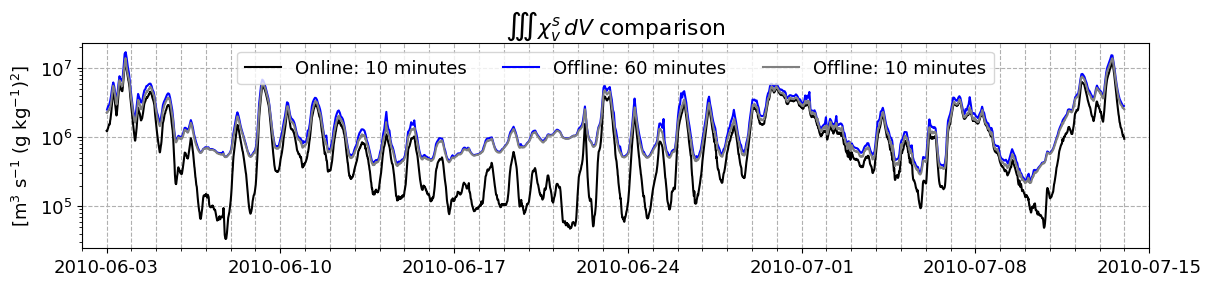

In [37]:
plt.rcParams.update({'font.size': 13})

time_60 = chiv_online_60.ocean_time.values
time_10 = chiv_online.ocean_time.values

myFmt = mdates.DateFormatter("%Y-%m-%d")
dates = ['2010-06-03', '2010-06-10', '2010-06-17', '2010-06-24',
         '2010-07-01', '2010-07-08', '2010-07-15']
#Convert date strings (e.g. 2014-10-18) to datetime
dates = [datetime.strptime(d, "%Y-%m-%d") for d in dates]

fig, ax = plt.subplots(1,1, figsize = (12,2.75*1), constrained_layout = True, sharey = False)

ax.semilogy(time_10, chiv_online_10, lw = 1.5, c = 'k', label = r'Online: 10 minutes')
# ax.semilogy(time_60, chiv_online_60, lw = 1.5, c = 'r', label = r'Online: 60 minutes')
ax.semilogy(time_60, chi_offline_60_nobc, lw = 1.5, c = 'b', label = r'Offline: 60 minutes')
ax.semilogy(time_10, chi_offline_10_nobc, lw = 1.5, c = 'grey', label = r'Offline: 10 minutes')

ax.set_title('$\iiint \chi_v^s \, dV$ comparison')
ax.legend(loc = 'upper center', ncol = 3)
ax.set_xlim(datetime(2010,6,2), datetime(2010,7,15))
ax.set_ylabel(r'[m$^3$ s$^{-1}$ (g kg$^{-1}$)$^2$]')
ax.set_xticks(ticks = dates)
ax.grid(linestyle = '--')
ax.set_xlabel('')

ax.xaxis.set_minor_locator(mdates.DayLocator())
ax.xaxis.grid(True, which = 'both', linestyle = '--')
    
plt.savefig('figures/reviewer1_offline_chi.jpg', dpi = 300, bbox_inches='tight')